## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices
* slide inference

In [1]:

import importlib.util
import os
import pickle
import sys
import time
from pathlib import Path

import pandas as pd
import torch.nn as nn
from torch.optim import AdamW
from tqdm.auto import tqdm

In [2]:
import socket
# MODEL_PROTO="Unet++"
exp_id = "Unet++_2.5d_Unimodel"
HOST = socket.gethostname()
date_time = time.strftime("%Y%m%d_%H%M%S")
run_id = exp_id + "_" + date_time


In [3]:
# noinspection PyUnresolvedReferences
is_kaggle = _dh == ["/kaggle/working"]
is_train = True
is_test = False

exp_id, HOST, is_kaggle

('Unet++_2.5d_Unimodel', 'Vincit', False)

In [4]:
if not is_kaggle:
    ROOT_DIR = Path("../").absolute()
    DATA_DIR = ROOT_DIR / "data" / "raw"
    OUTPUT_DIR = ROOT_DIR / "saved"
    CP_DIR = OUTPUT_DIR / "checkpoints"
    LOG_DIR = ROOT_DIR / "saved" / "logs"
    CACHE_DIR = ROOT_DIR / "saved" / "cache"
    EXTERNAL_MODELS_DIR = ROOT_DIR / "model"
else:
    ROOT_DIR = Path("/kaggle")
    DATA_DIR = ROOT_DIR / "input" / "vesuvius-challenge-ink-detection"
    OUTPUT_DIR = ROOT_DIR / "working"
    CP_DIR = OUTPUT_DIR / "ink-model"
    LOG_DIR = OUTPUT_DIR / "saved" / "logs"
    CACHE_DIR = OUTPUT_DIR / "saved" / "cache"
    EXTERNAL_MODELS_DIR = ROOT_DIR / "input"

print(f"ROOT_DIR: {ROOT_DIR}")

for p in [ROOT_DIR, DATA_DIR, OUTPUT_DIR, CP_DIR, LOG_DIR, CACHE_DIR]:
    if os.path.exists(p) is False:
        os.makedirs(p)

def to_pickle(filename, obj):
    with open(filename, mode="wb") as f:
        pickle.dump(obj, f)


def unpickle(filename):
    with open(filename, mode="rb") as fo:
        _ = pickle.load(fo)
    return _

ROOT_DIR: D:\Codes\python\kaggle\Vesuvius\dev\..


In [5]:
if is_test:
    # from tqdm import tqdm
    for i in tqdm(range(100)):
        pass

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

if not is_kaggle or True:
    # https://github.com/Cadene/pretrained-models.pytorch/issues/222
    import ssl

    ssl._create_default_https_context = ssl._create_unverified_context
if is_kaggle:
    sys.path.append(str(EXTERNAL_MODELS_DIR /"segmentation-models-pytorch" / "segmentation_models.pytorch-master"))
    sys.path.append(str(EXTERNAL_MODELS_DIR /"pretrainedmodels" / "pretrainedmodels-0.7.4"))
    sys.path.append(str(EXTERNAL_MODELS_DIR /"efficientnet-pytorch"/ "EfficientNet-PyTorch-master"))

    # noinspection PyUnresolvedReferences
    import segmentation_models_pytorch as smp

else:
    if importlib.util.find_spec("segmentation_models_pytorch") is None:
        !conda install -y segmentation-models-pytorch
    import segmentation_models_pytorch as smp
    # %%conda install -y -c conda-forge segmentation-models-pytorch



In [7]:

from torch.utils.data import DataLoader, Dataset
import cv2
import torch


## config

In [8]:
class Config:
    comp_name = "vesuvius"
    # ============== path =============
    comp_dataset_path = DATA_DIR  # dataset path
    cache_dir = CACHE_DIR  # cache directory
    data_dir = DATA_DIR  # data directory
    LOG_DIR = LOG_DIR  # log directory
    Note_book = exp_id  # notebook name
    model_dir = CP_DIR  # model directory
    exp_name = exp_id  # experiment name
    run_id = run_id  # run id
    HOST = HOST  # host name

    # ============== pred target =============
    target_size = 1  # prediction target size

    # ============== model cfg =============
    model_name = "Unet++"  # model name
    backbone = "se_resnext50_32x4d"  # model backbone
    in_channels = 32  # number of input channels
    resume = True  # resume training

    # ============== training cfg =============
    size = 224  # image size
    tile_size = 224  # tile size
    stride = 56  # tile stride

    batch_size = 16  # batch size
    use_amp = True  # use automatic mixed precision

    scheduler = "GradualWarmupSchedulerV2"  # learning rate scheduler
    epochs = 20  # number of training epochs
    PATIENCE = min(epochs // 2, 8)  # early stopping patience
    warmup_factor = 10  # warmup factor
    lr = 1e-5 / 10  # initial learning rate

    # ============== fold =============
    valid_id = 2  # validation fold id

    objective_cv = "binary"  # objective type
    metric_direction = "maximize"  # metric direction

    # ============== fixed =============
    pretrained = True  # use pre-trained weights
    inf_weight = "best"  # inference weight

    min_lr = 1e-6  # minimum learning rate
    weight_decay = 1e-6  # weight decay
    max_grad_norm = 1000  # maximum gradient norm

    print_freq = 50  # print frequency
    num_workers = 2  # number of workers
    seed = 3407  # random seed

    def __getitem__(self, item):
        return getattr(self, item)


_Config = Config()




In [9]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

CONFIG = {}
for k in dir(_Config):
    if not k.startswith("__"):
        CONFIG[k] = getattr(_Config, k)

for k in CONFIG.keys():
    if k not in CONFIG.keys():
        print(f"{k} is not in CONFIG")
    elif CONFIG[k] != CONFIG[k]:
        print(f"CONFIG {k} = {CONFIG[k]};is not equal to tmp {k} = {CONFIG[k]}")
    else:
        continue

for k in CONFIG.keys():
    if k not in CONFIG.keys():
        print(f"{k} is not in Config")
    else:
        continue

In [10]:
cfg = CONFIG

In [11]:


# ============== augmentation =============
def get_aug_list(size, in_channels, type='train'):
    """
    type: train, valid
    return: list of albumentations

    in case of any further modification,
    one should use albu.Compose by themselves
    """
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        albu.Resize(size, size),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.75),
        albu.ShiftScaleRotate(p=0.75),
        albu.OneOf([
            albu.GaussNoise(var_limit=(10.0, 50.0)),
            albu.GaussianBlur(),
            albu.MotionBlur(),
        ], p=0.4),
        albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        albu.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                           mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        albu.Resize(size, size),
        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels
        ),
        ToTensorV2(transpose_mask=True),
    ]

    if type == 'train':
        return train_aug_list
    else:
        return valid_aug_list




In [12]:
%%capture
# disable output of this cell
if not (is_kaggle or is_test):
    import wandb

    wandb.init(project=cfg['comp_name'], name=cfg['run_id'],
               config=CONFIG, dir=LOG_DIR)

    wandb.config['train_aug_list'] = albu.Compose(
        get_aug_list(cfg['size'], cfg['in_channels'], type='train')).to_dict()
    wandb.config['valid_aug_list'] = albu.Compose(
        get_aug_list(cfg['size'], cfg['in_channels'], type='valid')).to_dict()

In [13]:
import importlib.util


class AverageMeter(object):
    """Computes and stores the average and current value"""

    # if imported wandb, use wandb.log
    #

    def __init__(self, mode="train"):
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None
        self.mode = mode

        self.reset()
        self.use_wandb = (importlib.util.find_spec('wandb') is not None)

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
IS_DEBUG = True
mode = 'train' if IS_DEBUG else 'test'
TH = 0.4

## helper

In [15]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# def np_rle(img):
#     flat_img = np.where(img.flatten() , 1, 0).astype(np.uint8)
#     starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
#     ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
#     starts_ix = np.where(starts)[0] + 2
#     ends_ix = np.where(ends)[0] + 2
#     lengths = ends_ix - starts_ix
#     predicted_arr = np.stack([starts_ix, lengths]).T.flatten()
#     rle_str=np.array2string(predicted_arr.reshape(-1), separator=' ')
#     return rle_str[1:-1]

In [16]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))

    # remove existing handlers
    if logger.hasHandlers():
        logger.handlers.clear()

    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

In [17]:
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=str(cfg['LOG_DIR'] / cfg['run_id']) + '.log')

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


In [18]:
# img=cv2.imread(str(cfg['comp_dataset_path']/ f"/{mode}/1/mask.png"), 0)
# str1=rle(img)
# str2=np_rle(img)
# import cProfile
# cProfile.run('')
# cProfile.run('str2=np_rle(img)')

# assert str1 == str2


## dataset

In [19]:
# def read_image(fragment_id):
#     images = []
#
#     # idxs = range(65)
#     mid = 65 // 2
#     start = mid - cfg['in_channels'] // 2
#     end = mid + cfg['in_channels'] // 2
#     idxs = range(start, end)
#     logger.info(f"reading image fragment_id: {fragment_id}, idxs: {idxs}")
#
#     with tqdm(idxs) as pbar:
#         for i in pbar:
#             image = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/surface_volume/{i:02}.tif"), 0)
#
#             pad0 = (cfg['tile_size'] - image.shape[0] % cfg['tile_size'])
#             pad1 = (cfg['tile_size'] - image.shape[1] % cfg['tile_size'])
#
#             image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
#
#             images.append(image)
#     images = np.stack(images, axis=2)
#
#     return images

In [20]:
def get_transforms(mode, cfg):
    return albu.Compose(get_aug_list(cfg['size'], cfg['in_channels'], type=mode))


if not is_kaggle:
    from DataSets import CustomDataset
else:

    from cachetools import FIFOCache, cached


    class ImgLoader:

        def __init__(self, cache_dir: Path = None, data_dir: Path = None):
            self.cache_dir = cache_dir
            self.data_dir = data_dir

        def load_from_path(self, file_path: str = None, channel=6):
            return ImgLoader.load_from_path_static(self.cache_dir, self.data_dir, file_path, channel=channel)

        @staticmethod
        @cached(cache=FIFOCache(maxsize=10))
        def load_from_path_static(cache_dir: Path = None, data_dir: Path = None, file_path: str = None, channel=6):
            if isinstance(file_path, Path):
                file_path = str(file_path)

            assert not file_path.endswith('npy'), f"file path {file_path} is a npy file"
            assert os.path.exists(data_dir / file_path), f"file path {file_path} does not exist"

            path__npy_ = cache_dir / f"{file_path}.npy"

            if os.path.exists(path__npy_):
                img_l = np.load(str(path__npy_), allow_pickle=True)
                assert img_l is not None, f"Cached file {path__npy_} is None"
                return img_l

            if not os.path.exists(path__npy_.parent):
                os.makedirs(path__npy_.parent)

            if os.path.isfile(data_dir / file_path):
                img_l = cv2.imread(str(data_dir / file_path), 0)
                assert img_l is not None, f"Image file {data_dir / file_path} is None"
                np.save(str(path__npy_), img_l)
                return img_l

            if os.path.isdir(data_dir / file_path):
                path__npy_ = cache_dir / f"{file_path}_{channel}.npy"
                if os.path.exists(path__npy_):
                    img_l = np.load(str(path__npy_), allow_pickle=True)
                    assert img_l is not None, f"Cached file {path__npy_} is None"
                    return img_l

                img_l = []
                files = os.listdir(data_dir / file_path)
                mid = len(files) // 2
                start = mid - channel // 2
                end = mid + channel // 2
                assert start >= 0, f"start {start} is less than 0"
                assert end <= len(files), f"end {end} is greater than {len(files)}"

                files = files[start:end]
                for file in tqdm(files):
                    img_l.append(ImgLoader.load_from_path_static(cache_dir, data_dir, f"{file_path}/{file}"))

                img_l = np.stack(img_l, axis=2)
                np.save(str(path__npy_), img_l)
                return img_l


    class CustomDataset(Dataset):
        """"
        Custom Dataset for loading images, masks, and labels
        params:
            image_sets: list of image paths
            masks: list of mask paths
            labels: list of label paths
            transform: albumentations transform
            mode: train, valid, or test
        """

        def __init__(self, image_sets, cfg, masks=None, labels=None, transform=None, mode="train"):
            self.image_sets = image_sets
            self.cfg = cfg
            self.masks = masks
            self.labels = labels
            self.transform = transform
            self.type = mode
            self.imgLoader = None
            self.patch_num = []
            self.preprocess()

        def preprocess(self):
            if self.imgLoader is None:
                self.imgLoader = ImgLoader(
                    cache_dir=self.cfg['cache_dir'],
                    data_dir=self.cfg['data_dir'])

            for mask in self.masks:
                # mask may be path like or numpy array
                if isinstance(mask, (str, Path)):
                    mask = self.imgLoader.load_from_path(mask)

                x1_num = math.ceil((mask.shape[1] - self.cfg['tile_size']) / self.cfg['stride']) + 1
                y1_num = math.ceil((mask.shape[0] - self.cfg['tile_size']) / self.cfg['stride']) + 1

                self.patch_num.append((x1_num, y1_num))

            self.patch_num = np.array(self.patch_num)

        def get_gt(self, img_idx):
            return self.imgLoader.load_from_path(self.labels[img_idx])

        def get_mask(self, img_idx):
            return self.imgLoader.load_from_path(self.masks[img_idx])

        def __len__(self):
            x, y = np.transpose(self.patch_num)
            return x @ y

        def __getitem__(self, idx):
            # x1, y1, x2, y2 = self.xyxys[idx]
            img_id = 0
            patch_id = idx
            for i, patch_num in enumerate(self.patch_num):
                if patch_id < patch_num[0] * patch_num[1]:
                    img_id = i
                    break
                else:
                    patch_id -= patch_num[0] * patch_num[1]

            x1_num, y1_num = self.patch_num[img_id]
            x1 = (patch_id % x1_num) * self.cfg['stride']
            y1 = (patch_id // x1_num) * self.cfg['stride']
            x2 = x1 + self.cfg['tile_size']
            y2 = y1 + self.cfg['tile_size']

            img = self.imgLoader.load_from_path(self.image_sets[img_id], channel=self.cfg['in_channels'])
            mask = self.imgLoader.load_from_path(self.masks[img_id])

            img = img[y1:y2, x1:x2]
            mask = mask[y1:y2, x1:x2]

            if img.shape[0] != self.cfg['tile_size'] or img.shape[1] != self.cfg['tile_size']:
                pad_h = self.cfg['tile_size'] - img.shape[0]
                pad_w = self.cfg['tile_size'] - img.shape[1]
                img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode="constant", constant_values=0)
                mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

            if self.type in ["train", "valid"]:
                label = self.imgLoader.load_from_path(self.labels[img_id])
                label = label[y1:y2, x1:x2]
                if label.shape[0] != self.cfg['tile_size'] or label.shape[1] != self.cfg['tile_size']:
                    pad_h = self.cfg['tile_size'] - label.shape[0]
                    pad_w = self.cfg['tile_size'] - label.shape[1]
                    label = np.pad(label, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

                data = self.transform(image=img, mask=mask, label=label)
                label = data["label"].astype(np.float32)
            else:
                label = -1
                data = self.transform(image=img, mask=mask)

            # if mask != data["mask"]:
            #     print("mask is not equal")`
            #     fig, ax = plt.subplots(1, 2)
            #     ax[0].imshow(mask)
            #     ax[1].imshow(data["mask"])
            #     ax[0].set_title("mask")
            #     ax[1].set_title("data[mask]")
            #     plt.show()
            image = data["image"]
            mask = data["mask"]

            return image, mask, label, (x1, y1, x2, y2)


In [21]:
def make_dataset(img_set_ids,mode='train', dataset_mode='train'):
    imgs = []
    masks = []
    labels = []
    for set_id in img_set_ids:
        imgs.append(f"{mode}/{set_id}/surface_volume")
        masks.append(f"{mode}/{set_id}/mask.png")
        labels.append(f"{mode}/{set_id}/inklabels.png")

    # test_images = read_image(fragment_id)
    #
    # x1_list = list(range(0, test_images.shape[1] - cfg['tile_size']+ 1, cfg['stride']))
    # y1_list = list(range(0, test_images.shape[0] - cfg['tile_size']+ 1, cfg['stride']))
    #
    # test_images_list = []
    # xyxys = []
    # for y1 in y1_list:
    #     for x1 in x1_list:
    #         y2 = y1 + cfg['tile_size']
    #         x2 = x1 + cfg['tile_size']
    #         test_images_list.append(test_images[y1:y2, x1:x2])
    #         xyxys.append((x1, y1, x2, y2))
    # xyxys = np.stack(xyxys)

    dataset = CustomDataset(
        image_sets=imgs,
        cfg=cfg,
        masks=masks,
        labels=labels,
        mode=dataset_mode,
        transform=get_transforms(mode=dataset_mode, cfg=cfg))

    loader = DataLoader(
        dataset,
        batch_size=cfg['batch_size'],
        shuffle=False,
        num_workers=cfg['num_workers'],
        pin_memory=True,
        drop_last=False)

    return loader

In [22]:
# def make_dataset(img_set_id, mode='train',data_set='train'):
#
#     imgs_path= cfg['comp_dataset_path']/ f"{data_set}/{img_set_id}/surface_volume"

## model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg
        self.th = 0.5
        self.encoder = smp.UnetPlusPlus(
            encoder_name=cfg['backbone'],
            encoder_weights=weight,
            in_channels=cfg['in_channels'],
            classes=cfg['target_size'],
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def get_saved_model_path(cfg, fold=1):
    return str(cfg['model_dir'] / f'{cfg["model_name"]}_{cfg["in_channels"]}best.pth')


# def get_model_path(cfg, fold=1):
#     """
#     return saved model path if exists, otherwise return external model path
#     """
#     if os.path.exists(get_saved_model_path(cfg, fold)):
#         return get_saved_model_path(cfg, fold)
#     else:
#         _tmp = str(EXTERNAL_MODELS_DIR / f"{cfg['exp_name']}/vesuvius-models/Unet_fold{fold}_best.pth'")
#         Logger.info(f'trained model not found \n'
#                     f'load model from {_tmp}')
#     return _tmp


def build_model(cfg, weight="imagenet"):
    Logger.info(f"model_name: {cfg['model_name']}")
    Logger.info(f"backbone: {cfg['backbone']}")
    if cfg['resume']:
        model_path = get_saved_model_path(cfg)
        if os.path.exists(model_path):
            Logger.info(f'load model from: {model_path}')
            _model = CustomModel(cfg, weight=None)
            loaded_model = torch.load(model_path)
            # print(loaded_model)
            _model.load_state_dict(loaded_model['model'])
            # best_loss = loaded_model['best_loss']
            # best_loss = None if loaded_model['best_loss'] is None else loaded_model['best_loss']
            best_loss = loaded_model['best_loss']
            th=loaded_model['th'] if 'th' in loaded_model else 0.5
            _model.th = th
            return _model, best_loss
        Logger.info(f'trained model not found')

    if is_kaggle:
        weight = None
    _model = CustomModel(cfg, weight)
    return _model, None




In [24]:
# class EnsembleModel:
#     def __init__(self, use_tta=False):
#         self.models = []
#         self.use_tta = use_tta
#
#     def __call__(self, x):
#         outputs = [torch.sigmoid(model(x)).to('cpu').numpy()
#                    for model in self.models]
#         avg_preds = np.mean(outputs, axis=0)
#         return avg_preds
#
#     def add_model(self, model):
#         self.models.append(model)
#
#
# def build_ensemble_model():
#     # if mode == 'test'
#     #  load from saved model
#     _model = EnsembleModel()
#     for _fold in [1, 2, 3]:
#         model = build_model(cfg, weight=None,fold=_fold)
#         model.to(device)
#
#         # model_path = get_model_path(CONFIG, fold=_fold)
#         # state = torch.load(model_path)['model']
#         # model.load_state_dict(state)
#         model.eval()
#
#         _model.add_model(model)
#
#     return _model

In [25]:
if mode == 'test':
    fragment_ids = sorted(os.listdir(cfg['comp_dataset_path'] / mode))
else:
    fragment_ids = [3]

In [26]:
# def score(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#
#     # use F0.5 score
#     B = 0.5
#     B2 = B * B
#     TruePositive = np.sum(y_true * y_pred)
#     FalsePositive = np.sum((1 - y_true) * y_pred)
#     FalseNegative = np.sum(y_true * (1 - y_pred))
#     p = TruePositive / (TruePositive + FalsePositive + 1e-6)
#     r = TruePositive / (TruePositive + FalseNegative + 1e-6)
#     score = (1 + B2) * p * r / (B2 * p + r + 1e-6)
#     return score

In [27]:
# model = build_ensemble_model()

## Scheduler

In [28]:

import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingLR


# from warmup_scheduler import GradualWarmupScheduler


# class GradualWarmupSchedulerV2(GradualWarmupScheduler):
#     """
#     https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
#     """
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
#         super(GradualWarmupSchedulerV2, self).__init__(
#             optimizer, multiplier, total_epoch, after_scheduler)
#
#     def get_lr(self):
#         if self.last_epoch > self.total_epoch:
#             if self.after_scheduler:
#                 if not self.finished:
#                     self.after_scheduler.base_lrs = [
#                         base_lr * self.multiplier for base_lr in self.base_lrs]
#                     self.finished = True
#                 return self.after_scheduler.get_lr()
#             return [base_lr * self.multiplier for base_lr in self.base_lrs]
#         if self.multiplier == 1.0:
#             return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
#         else:
#             return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = CosineAnnealingLR(
        optimizer, cfg["epochs"], eta_min=1e-7)
    # scheduler = GradualWarmupSchedulerV2(
    #     optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler_cosine


def scheduler_step(scheduler, avg_val_loss, epoch):
    # scheduler.step(epoch)
    scheduler.step()

## Metrics

In [29]:


def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-6):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets == 1].sum()
    cfp = preds[targets == 0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice


def calc_fbeta(label_gt, label_pred):
    assert label_gt.shape == label_pred.shape, f'mask.shape:{label_gt.shape} != mask_pred.shape:{label_pred.shape}'
    label_gt = label_gt.astype(int).flatten()
    label_pred = label_pred.flatten()

    best_th = 0
    best_dice = 0
    # for th in np.array(range(10, 50 + 1, 5)) / 100:
    for th in np.linspace(10, 96, 10) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        # print(label_pred.max())
        dice = fbeta_numpy(label_gt, (label_pred >= th).astype(int), beta=0.5)
        Logger.info(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th

    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## Loss

In [30]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)


def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train and valid

In [31]:
from torch.cuda.amp import autocast, GradScaler


def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CONFIG["use_amp"])
    losses = AverageMeter()

    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for step, data in pbar:
            images, masks, labels, positions = data

            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with autocast(CONFIG["use_amp"]):
                y_preds = model(images).squeeze()
                labels = labels.squeeze()

                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            scaler.scale(loss).backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), CONFIG["max_grad_norm"])

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    return losses.avg


def valid_fn(valid_loader, model, criterion, device, valid_mask_gt):
    label_pred = np.zeros(valid_mask_gt.shape)
    label_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter(mode='valid')

    with tqdm(enumerate(valid_loader), total=len(valid_loader)) as pbar:
        for step, (images, masks, labels, positions) in pbar:

            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with torch.no_grad():
                y_preds = model(images).squeeze()
                labels = labels.squeeze()
                loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)

            # make whole mask
            y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
            # start_idx = step*CONFIG["valid_batch_size"]             # end_idx = start_idx + batch_size
            # print(positions)
            for i, (x1, y1, x2, y2) in enumerate(zip(*positions)):
                label_pred[y1:y2, x1:x2] += y_preds[i]
                label_count[y1:y2, x1:x2] += np.ones((y2 - y1, x2 - x1))

    Logger.info(f'mask_count_min: {label_count.min()}')
    label_pred /= label_count + 1e-8
    return losses.avg, label_pred

def test_fn(test_loader, model, device,mask_gt):
    model.eval()
    label_pred = np.zeros(mask_gt.shape)
    label_count = np.zeros(mask_gt.shape)
    with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
        for step, (images, masks, labels, positions) in pbar:

            images = images.to(device)
            labels = labels.to(device)
            batch_size = labels.size(0)

            with torch.no_grad():
                y_preds = model(images).squeeze()

            # make whole mask
            y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
            # start_idx = step*CONFIG["valid_batch_size"]             # end_idx = start_idx + batch_size
            # print(positions)
            for i, (x1, y1, x2, y2) in enumerate(zip(*positions)):
                label_pred[y1:y2, x1:x2] += y_preds[i]
                label_count[y1:y2, x1:x2] += np.ones((y2 - y1, x2 - x1))
    label_pred /= label_count + 1e-8
    return label_pred


In [32]:
import shutil


# TODO
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:

            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            Logger.info(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:

            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""

        self.best_score = score
        if self.verbose:
            Logger.info(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )

        self.val_loss_min = val_loss

        save_path = get_saved_model_path(cfg)
        if os.path.exists(save_path):
            shutil.move(save_path, save_path.replace('.pt', '-bkp.pt'))

        torch.save(
            {"model": model.state_dict(),
             "best_loss": -score,
             "th": model.th
             }
            , save_path)
        self.val_loss_min = val_loss

In [33]:
pass
# results = []
# for fragment_id in fragment_ids:

# def test(fragment_id):
#     model= build_ensemble_model()
#     test_loader = make_dataset(fragment_id, dataset_mode='test')
#
#     # binary_mask = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/mask.png"), 0)
#     binary_mask = test_loader.dataset.imgLoader.load_from_path(test_loader.dataset.masks[0])
#     binary_mask = (binary_mask / 255).astype(int)
#
#     ori_h = binary_mask.shape[0]
#     ori_w = binary_mask.shape[1]
#     # mask = mask / 255
#
#     pad0 = (cfg['tile_size'] - binary_mask.shape[0] % cfg['tile_size'])
#     pad1 = (cfg['tile_size'] - binary_mask.shape[1] % cfg['tile_size'])
#
#     Logger.info("trunk test")
#     binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
#
#     mask_pred = np.zeros(binary_mask.shape)
#     mask_count = np.zeros(binary_mask.shape)
#     with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
#         for step, (image,mask,label,pos) in pbar:
#             # for step, (images) in tqdm(enumerate(test_loader)):
#             # MEMO The image wil be a list in size of batch size
#             images = images.to(device)
#             batch_size = images.size(0)
#
#             with torch.no_grad():
#                 y_preds = model(images)
#
#             # start_idx = step * cfg['batch_size']
#             # end_idx = start_idx + batch_size
#             for (x1, y1, x2, y2), y_pred in zip(pos, y_preds):
#                 mask_pred[y1:y2, x1:x2] += y_pred.squeeze(0)
#                 mask_count[y1:y2, x1:x2] += np.ones((cfg['tile_size'], cfg['tile_size']))
#             # for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
#             #     mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
#             #     mask_count[y1:y2, x1:x2] += np.ones((cfg['tile_size'], cfg['tile_size']))
#
#     if is_test:
#         plt.imshow(mask_count)
#         plt.show()
#
#     Logger.info(f'mask_count_min: {mask_count.min()}')
#     mask_pred /= mask_count
#
#     mask_pred = mask_pred[:ori_h, :ori_w]
#     binary_mask = binary_mask[:ori_h, :ori_w]
#
#     mask_pred = (mask_pred >= TH).astype(int)
#     mask_pred *= binary_mask
#
#     inklabels_rle = rle(mask_pred)
#
#     results.append((fragment_id, inklabels_rle))
#     label_true = cv2.imread(str(cfg['comp_dataset_path'] / f"{mode}/{fragment_id}/inklabels.png"), 0)
#
#     fig, ax = plt.subplots(1, 2, figsize=(20, 20))
#     ax[0].imshow(mask_pred)
#     ax[0].title.set_text('pred')
#     ax[1].imshow(label_true)
#     ax[1].title.set_text('true')
#     F05 = score(mask_pred, label_true)
#     Logger.info('score', F05)
#     # plt.show()
#     # wandb.run.summary(f"score_{fragment_id}", F05)
#     wandb.log({"test_score": F05})
#     wandb.log({"test_img": [wandb.Image(fig, caption=f"score_{fragment_id}")]})
#
#     del mask_pred, mask_count
#     del test_loader
#
#     gc.collect()
#     torch.cuda.empty_cache()


In [34]:
# if is_test:
#     Logger.info(y_preds[0].shape)
#     str(CONFIG["comp_dataset_path"] / f"{mode}/{fragment_id}/inklabel.png")
pass

In [35]:
# CFG = CONFIG
# wandb.log({"test_score": F05})
# wandb.log({"test_img": [wandb.Image(fig, caption=f"score_{fragment_id}")]})

Logger.info(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2023-04-25 21:32:25


## Main

In [36]:
# if is_test:
# import cProfile
# from time import sleep
# def bench():
#     train_loader = make_dataset([1, 2], dataset_mode='train')
#     train_dataset = train_loader.dataset
#     sample = next(iter(train_dataset))
#     with tqdm(enumerate(train_dataset), total=len(train_dataset)) as pbar:
#         for step, data in pbar:
#             for i in range(3):
#
#                 assert sample[i].shape == data[i].shape, f"in step {step} " \
#                                                          f"sample[{i}].shape: {sample[i].shape} != data[{i}].shape: {data[i].shape}"
#
# cProfile.run('bench()', sort='cumtime')


In [37]:


# foldset = []
# foldset.append({
#     'train': [1, 2],
#     'valid': [3]
# })
# foldset.append({
#     'train': [1, 3],
#     'valid': [2]
# })
# foldset.append({
#     'train': [2, 3],
#     'valid': [1]
# })
# # fold = cfg['valid_id']
# if cfg['metric_direction'] == 'minimize':
#     best_score = np.inf
# elif cfg['metric_direction'] == 'maximize':
#     best_score = -1
# else:
#     best_score = 0
#
# best_lo

In [38]:
pass
# for fold in foldset:
#     train_loader = make_dataset([1, 2], dataset_mode='train')
#     valid_loader = make_dataset([3], dataset_mode='valid')
#     valid_mask_gt = valid_loader.dataset.get_gt(0)
#
#     if valid_mask_gt.max() > 1:
#         Logger.info(f'valid_mask_gt.shape: {valid_mask_gt.shape} \n'
#                     f'valid_mask_gt.max: {valid_mask_gt.max()} \n')
#         valid_mask_gt = valid_mask_gt / 255
#
#     pad0 = (CONFIG["tile_size"] - valid_mask_gt.shape[0] % CONFIG["tile_size"])
#     pad1 = (CONFIG["tile_size"] - valid_mask_gt.shape[1] % CONFIG["tile_size"])
#     valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)
#
#     model = build_model(cfg)
#     model.to(device)
#
#     optimizer = AdamW(model.parameters(), lr=CONFIG["lr"])
#     scheduler = get_scheduler(CONFIG, optimizer)
#
#     for epoch in range(CONFIG["epochs"]):
#
#         start_time = time.time()
#
#         # train
#         avg_loss = train_fn(train_loader, model, criterion, optimizer, device)
#
#         # eval
#         avg_val_loss, mask_pred = valid_fn(
#             valid_loader, model, criterion, device, valid_mask_gt)
#
#         scheduler_step(scheduler, avg_val_loss, epoch)
#
#         best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)
#
#         # score = avg_val_loss
#         score = best_dice
#
#         elapsed = time.time() - start_time
#
#         Logger.info(
#             f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#         # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
#         Logger.info(
#             f'Epoch {epoch + 1} - avgScore: {score:.4f}')
#
#         if CONFIG["metric_direction"] == 'minimize':
#             update_best = score < best_score
#         elif CONFIG["metric_direction"] == 'maximize':
#             update_best = score > best_score
#
#         if update_best:
#             best_loss = avg_val_loss
#             best_score = score
#
#             Logger.info(
#                 f'Epoch {epoch + 1} - Save Best Score: {best_score:.4f} Model')
#             Logger.info(
#                 f'Epoch {epoch + 1} - Save Best Loss: {best_loss:.4f} Model')
#
#             torch.save({'model': model.state_dict(),
#                         'preds': mask_pred},
#                        CONFIG["model_dir"] + f'{CONFIG["model_name"]}_fold{fold}_best.pth')

In [39]:
# import numpy as np
# import time
# from torch.optim import AdamW


def create_foldset():
    foldset = []
    foldset.append({
        'train': [1, 2],
        'valid': [3]
    })
    foldset.append({
        'train': [1, 3],
        'valid': [2]
    })
    foldset.append({
        'train': [2, 3],
        'valid': [1]
    })
    return foldset


def get_best_score(metric_direction):
    if metric_direction == 'minimize':
        return np.inf
    elif metric_direction == 'maximize':
        return -1
    else:
        return 0


def preprocess_valid_mask_gt(valid_mask_gt, tile_size):
    if valid_mask_gt.max() > 1:
        Logger.info(f'valid_mask_gt.shape: {valid_mask_gt.shape} \n'
                    f'valid_mask_gt.max: {valid_mask_gt.max()} \n')
        valid_mask_gt = valid_mask_gt / 255

    pad0 = (tile_size - valid_mask_gt.shape[0] % tile_size)
    pad1 = (tile_size - valid_mask_gt.shape[1] % tile_size)
    valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

    return valid_mask_gt


def should_update_best_score(metric_direction, score, best_score):
    if metric_direction == 'minimize':
        return score < best_score
    elif metric_direction == 'maximize':
        return score > best_score


In [40]:
# fold_configs = create_foldset()
#
# best_score = -1 if CONFIG["metric_direction"] == 'maximize' else np.inf
# best_loss = np.inf
#
# # CONFIG["epochs"] = 4
# model = build_model(cfg,fold=fold_configs[0]["valid"][0])

In [41]:


import gc

fold_configs = create_foldset()

# best_score = -1 if CONFIG["metric_direction"] == 'maximize' else np.inf


# CONFIG["epochs"] = 4
# TODO the best score should be compared
# with the best score of the loaded model
# if there's any
Logger.info(CONFIG)

model, best_loss = build_model(cfg)
best_loss = best_loss if best_loss is not None else np.inf
model.to(device)
early_stopping = EarlyStopping(
    patience=Config.PATIENCE, verbose=True
)
for epoch in range(CONFIG["epochs"]):
    optimizer = AdamW(model.parameters(), lr=CONFIG["lr"])
    scheduler = get_scheduler(CONFIG, optimizer)

    for fold_config in fold_configs:
        train_loader = make_dataset(fold_config["train"], dataset_mode='train')
        valid_loader = make_dataset(fold_config["valid"], dataset_mode='valid')

        Logger.info(f'fold_config: {fold_config}')

        valid_mask_gt = valid_loader.dataset.get_gt(0)

        valid_mask_gt = preprocess_valid_mask_gt(valid_mask_gt, CONFIG["tile_size"])


        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

        # eval
        avg_val_loss, label_pred = valid_fn(
            valid_loader, model, criterion, device, valid_mask_gt)

        scheduler_step(scheduler, avg_val_loss, epoch)

        best_dice, best_th = calc_cv(valid_mask_gt, label_pred)

        model.th = best_th

        # score = avg_val_loss
        score = best_dice

        elapsed = time.time() - start_time

        early_stopping(score, model)

        Logger.info(
            f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        Logger.info(
            f'Epoch {epoch + 1} - avgScore: {score:.4f}')
        if not is_kaggle:
            wandb.log({
                "train_loss": avg_loss,
                "val_loss": avg_val_loss,
                "best_dice": best_dice,
                "best_th": best_th,
                "best_loss": best_loss,
            })

        if early_stopping.early_stop:
            Logger.info("Early stopping")
            break
    if early_stopping.early_stop:
        Logger.info("Early stopping")
        break

del model, optimizer, scheduler, early_stopping, train_loader, valid_loader
torch.cuda.empty_cache()
gc.collect()



{'HOST': 'Vincit', 'LOG_DIR': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/logs'), 'Note_book': 'Unet++_2.5d_Unimodel', 'PATIENCE': 8, 'backbone': 'se_resnext50_32x4d', 'batch_size': 16, 'cache_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/cache'), 'comp_dataset_path': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../data/raw'), 'comp_name': 'vesuvius', 'data_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../data/raw'), 'epochs': 20, 'exp_name': 'Unet++_2.5d_Unimodel', 'in_channels': 32, 'inf_weight': 'best', 'lr': 1.0000000000000002e-06, 'max_grad_norm': 1000, 'metric_direction': 'maximize', 'min_lr': 1e-06, 'model_dir': WindowsPath('D:/Codes/python/kaggle/Vesuvius/dev/../saved/checkpoints'), 'model_name': 'Unet++', 'num_workers': 2, 'objective_cv': 'binary', 'pretrained': True, 'print_freq': 50, 'resume': True, 'run_id': 'Unet++_2.5d_Unimodel_20230425_213216', 'scheduler': 'GradualWarmupSchedulerV2', 'seed': 3407, 'size': 224, 'stride': 56, '

  0%|          | 0/2711 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.13000671128292843
th: 0.19555555555555557, fbeta: 0.13017692807235012
th: 0.2911111111111111, fbeta: 0.13256936609824085
th: 0.38666666666666666, fbeta: 0.1479335640192867
th: 0.4822222222222222, fbeta: 0.15452208690793712
th: 0.5777777777777778, fbeta: 0.15922092044231398
th: 0.6733333333333333, fbeta: 0.15060823316816746
th: 0.7688888888888888, fbeta: 0.07919031602253862
th: 0.8644444444444445, fbeta: 0.003801651950497544
th: 0.96, fbeta: 0.0
best_th: 0.5777777777777778, fbeta: 0.15922092044231398
Validation loss decreased (inf --> 0.159221).  Saving model ...
Epoch 1 - avg_train_loss: 4.5581  avg_val_loss: -14.3638  time: 836s
Epoch 1 - avgScore: 0.1592
fold_config: {'train': [1, 3], 'valid': [2]}
valid_mask_gt.shape: (14830, 9506) 
valid_mask_gt.max: 255 



  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/2062 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.1885950778101311
th: 0.19555555555555557, fbeta: 0.18876104324883922
th: 0.2911111111111111, fbeta: 0.19063859181060003
th: 0.38666666666666666, fbeta: 0.2043526626777484
th: 0.4822222222222222, fbeta: 0.2105131561082087
th: 0.5777777777777778, fbeta: 0.21832507605189877
th: 0.6733333333333333, fbeta: 0.22031868578082375
th: 0.7688888888888888, fbeta: 0.1899836465745281
th: 0.8644444444444445, fbeta: 0.05031006365964676
th: 0.96, fbeta: 0.0001757933969415592
best_th: 0.6733333333333333, fbeta: 0.22031868578082375
EarlyStopping counter: 1 out of 8
Epoch 1 - avg_train_loss: -6.0090  avg_val_loss: -32.0475  time: 507s
Epoch 1 - avgScore: 0.2203
fold_config: {'train': [2, 3], 'valid': [1]}
valid_mask_gt.shape: (8181, 6330) 
valid_mask_gt.max: 255 



  0%|          | 0/2611 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.18273914904214736
th: 0.19555555555555557, fbeta: 0.18306152459270175
th: 0.2911111111111111, fbeta: 0.19694404460146714
th: 0.38666666666666666, fbeta: 0.21378860189940554
th: 0.4822222222222222, fbeta: 0.22125554374358994
th: 0.5777777777777778, fbeta: 0.23057462665069933
th: 0.6733333333333333, fbeta: 0.23773472736498386
th: 0.7688888888888888, fbeta: 0.24446242047176672
th: 0.8644444444444445, fbeta: 0.23670065377895297
th: 0.96, fbeta: 0.01841265083858159
best_th: 0.7688888888888888, fbeta: 0.24446242047176672
EarlyStopping counter: 2 out of 8
Epoch 1 - avg_train_loss: -13.0734  avg_val_loss: -70.7538  time: 620s
Epoch 1 - avgScore: 0.2445
fold_config: {'train': [1, 2], 'valid': [3]}
valid_mask_gt.shape: (7606, 5249) 
valid_mask_gt.max: 255 



  0%|          | 0/2711 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.13012054493168201
th: 0.19555555555555557, fbeta: 0.1305925204983326
th: 0.2911111111111111, fbeta: 0.13699877891677675
th: 0.38666666666666666, fbeta: 0.14823985472581303
th: 0.4822222222222222, fbeta: 0.1513178847125827
th: 0.5777777777777778, fbeta: 0.15464631127487483
th: 0.6733333333333333, fbeta: 0.1599863111821079
th: 0.7688888888888888, fbeta: 0.1660465838036763
th: 0.8644444444444445, fbeta: 0.1757919362017759
th: 0.96, fbeta: 0.08342594484630741
best_th: 0.8644444444444445, fbeta: 0.1757919362017759
EarlyStopping counter: 3 out of 8
Epoch 2 - avg_train_loss: -22.0261  avg_val_loss: -61.4446  time: 628s
Epoch 2 - avgScore: 0.1758
fold_config: {'train': [1, 3], 'valid': [2]}
valid_mask_gt.shape: (14830, 9506) 
valid_mask_gt.max: 255 



  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/2062 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.18854450876558052
th: 0.19555555555555557, fbeta: 0.1885993415022478
th: 0.2911111111111111, fbeta: 0.19771767131283036
th: 0.38666666666666666, fbeta: 0.2048348216837624
th: 0.4822222222222222, fbeta: 0.20838933337808338
th: 0.5777777777777778, fbeta: 0.21305267874912806
th: 0.6733333333333333, fbeta: 0.21934586142370727
th: 0.7688888888888888, fbeta: 0.22671730932837772
th: 0.8644444444444445, fbeta: 0.2392803575087029
th: 0.96, fbeta: 0.1793115439073452
best_th: 0.8644444444444445, fbeta: 0.2392803575087029
EarlyStopping counter: 4 out of 8
Epoch 2 - avg_train_loss: -23.3509  avg_val_loss: -95.6102  time: 500s
Epoch 2 - avgScore: 0.2393
fold_config: {'train': [2, 3], 'valid': [1]}
valid_mask_gt.shape: (8181, 6330) 
valid_mask_gt.max: 255 



  0%|          | 0/2611 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.18271944282638378
th: 0.19555555555555557, fbeta: 0.18272233420608344
th: 0.2911111111111111, fbeta: 0.18426534955278862
th: 0.38666666666666666, fbeta: 0.20846361465735203
th: 0.4822222222222222, fbeta: 0.21693573498951377
th: 0.5777777777777778, fbeta: 0.22452963603563275
th: 0.6733333333333333, fbeta: 0.23162487837016887
th: 0.7688888888888888, fbeta: 0.2372615059687897
th: 0.8644444444444445, fbeta: 0.24606090882526638
th: 0.96, fbeta: 0.2153675488110214
best_th: 0.8644444444444445, fbeta: 0.24606090882526638
EarlyStopping counter: 5 out of 8
Epoch 2 - avg_train_loss: -29.3807  avg_val_loss: -111.6551  time: 636s
Epoch 2 - avgScore: 0.2461
fold_config: {'train': [1, 2], 'valid': [3]}
valid_mask_gt.shape: (7606, 5249) 
valid_mask_gt.max: 255 



  0%|          | 0/2711 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.13030537580412185
th: 0.19555555555555557, fbeta: 0.1307725895031499
th: 0.2911111111111111, fbeta: 0.13312953182993428
th: 0.38666666666666666, fbeta: 0.14575463132255975
th: 0.4822222222222222, fbeta: 0.15020477798467485
th: 0.5777777777777778, fbeta: 0.15237536639100785
th: 0.6733333333333333, fbeta: 0.15597753748901239
th: 0.7688888888888888, fbeta: 0.1608768227001793
th: 0.8644444444444445, fbeta: 0.16554049363692688
th: 0.96, fbeta: 0.18311679201864164
best_th: 0.96, fbeta: 0.18311679201864164
EarlyStopping counter: 6 out of 8
Epoch 3 - avg_train_loss: -37.0946  avg_val_loss: -94.4486  time: 628s
Epoch 3 - avgScore: 0.1831
fold_config: {'train': [1, 3], 'valid': [2]}
valid_mask_gt.shape: (14830, 9506) 
valid_mask_gt.max: 255 



  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/2062 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.18854193949754874
th: 0.19555555555555557, fbeta: 0.18855196699192808
th: 0.2911111111111111, fbeta: 0.18869892559081278
th: 0.38666666666666666, fbeta: 0.19831501757141168
th: 0.4822222222222222, fbeta: 0.20760411777229407
th: 0.5777777777777778, fbeta: 0.21205691569583981
th: 0.6733333333333333, fbeta: 0.21722820288779013
th: 0.7688888888888888, fbeta: 0.22226466867198927
th: 0.8644444444444445, fbeta: 0.23142731935911307
th: 0.96, fbeta: 0.2578682797270032
best_th: 0.96, fbeta: 0.2578682797270032
EarlyStopping counter: 7 out of 8
Epoch 3 - avg_train_loss: -34.9302  avg_val_loss: -126.5962  time: 501s
Epoch 3 - avgScore: 0.2579
fold_config: {'train': [2, 3], 'valid': [1]}
valid_mask_gt.shape: (8181, 6330) 
valid_mask_gt.max: 255 



  0%|          | 0/2611 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

mask_count_min: 0.0
th: 0.1, fbeta: 0.1827194328217686
th: 0.19555555555555557, fbeta: 0.18272077344996623
th: 0.2911111111111111, fbeta: 0.18282585883465857
th: 0.38666666666666666, fbeta: 0.2013480503870657
th: 0.4822222222222222, fbeta: 0.21504365774607473
th: 0.5777777777777778, fbeta: 0.22197381671923458
th: 0.6733333333333333, fbeta: 0.22895195504755816
th: 0.7688888888888888, fbeta: 0.2352138343804319
th: 0.8644444444444445, fbeta: 0.24180686575712326
th: 0.96, fbeta: 0.25539963349232014
best_th: 0.96, fbeta: 0.25539963349232014
EarlyStopping counter: 8 out of 8
Epoch 3 - avg_train_loss: -41.3408  avg_val_loss: -153.8873  time: 619s
Epoch 3 - avgScore: 0.2554
Early stopping
Early stopping


751

In [42]:

from matplotlib import pyplot as plt


def predict(img_set_ids, model, device,mode='test'):
    _mode=mode if mode == 'test' else 'train'
    imgs = []
    masks = []
    labels = []
    for set_id in img_set_ids:
        imgs.append(f"{_mode}/{set_id}/surface_volume")
        masks.append(f"{_mode}/{set_id}/mask.png")
        labels.append(f"{_mode}/{set_id}/inklabels.png")

    test_dataset = CustomDataset(
        image_sets=imgs,
        cfg=cfg,
        masks=masks,
        labels=labels,
        mode=mode,
        transform=get_transforms(mode=mode, cfg=cfg))

    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=CONFIG["num_workers"],
        pin_memory=True,
        drop_last=False,
    )
    mask_gt = test_dataset.get_mask(0)
    label_pred = test_fn(test_loader, model, device,mask_gt=preprocess_valid_mask_gt(mask_gt, CONFIG["tile_size"]))

    # mask_gt = preprocess_valid_mask_gt(mask_gt, CONFIG["tile_size"])
    label_pred=label_pred[:mask_gt.shape[0],:mask_gt.shape[1]]
    # Consider mask then calculate the best threshold
    label_pred *= (mask_gt/255)

    if mode=='valid':
        label_gt = test_dataset.get_gt(0)/255
        best_dice, best_th = calc_cv(label_gt, label_pred)
        print(f'best_dice: {best_dice} best_th: {best_th} using th {model.th}')

        fig, ax = plt.subplots(1, 3, figsize=(20, 10))
        ax[0].imshow(label_gt)
        ax[0].set_title('label_gt')
        ax[1].imshow(label_pred)
        ax[1].set_title('label_pred')

        label_pred = (label_pred > model.th).astype(np.uint8)
        ax[2].imshow(label_pred)
        ax[2].set_title('binary_label')
        plt.show()
    else:
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax[0].imshow(label_pred)
        ax[0].set_title('label_pred')
        label_pred = (label_pred > model.th).astype(np.uint8)
        ax[1].imshow(label_pred)
        ax[1].set_title('binary_label')

    return label_pred


In [43]:
# if is_test:


NameError: name 'model' is not defined

 ## submission

model_name: Unet++
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpoints\Unet++_32best.pth
valid_mask_gt.shape: (2727, 6330) 
valid_mask_gt.max: 255 



  0%|          | 0/233 [00:00<?, ?it/s]

model_name: Unet++
backbone: se_resnext50_32x4d
load model from: D:\Codes\python\kaggle\Vesuvius\dev\..\saved\checkpoints\Unet++_32best.pth
valid_mask_gt.shape: (5454, 6330) 
valid_mask_gt.max: 255 



  0%|          | 0/401 [00:00<?, ?it/s]

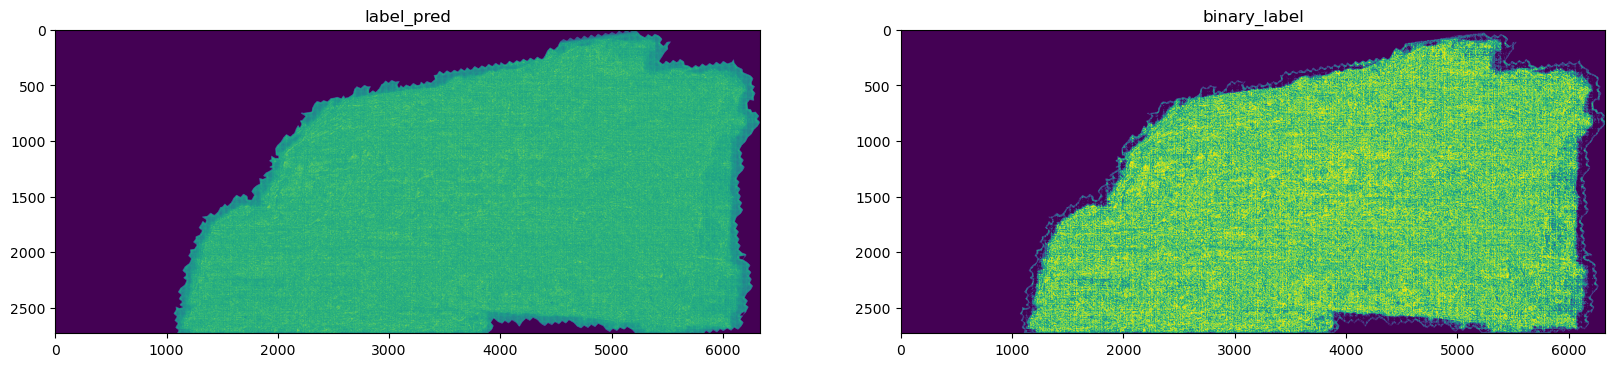

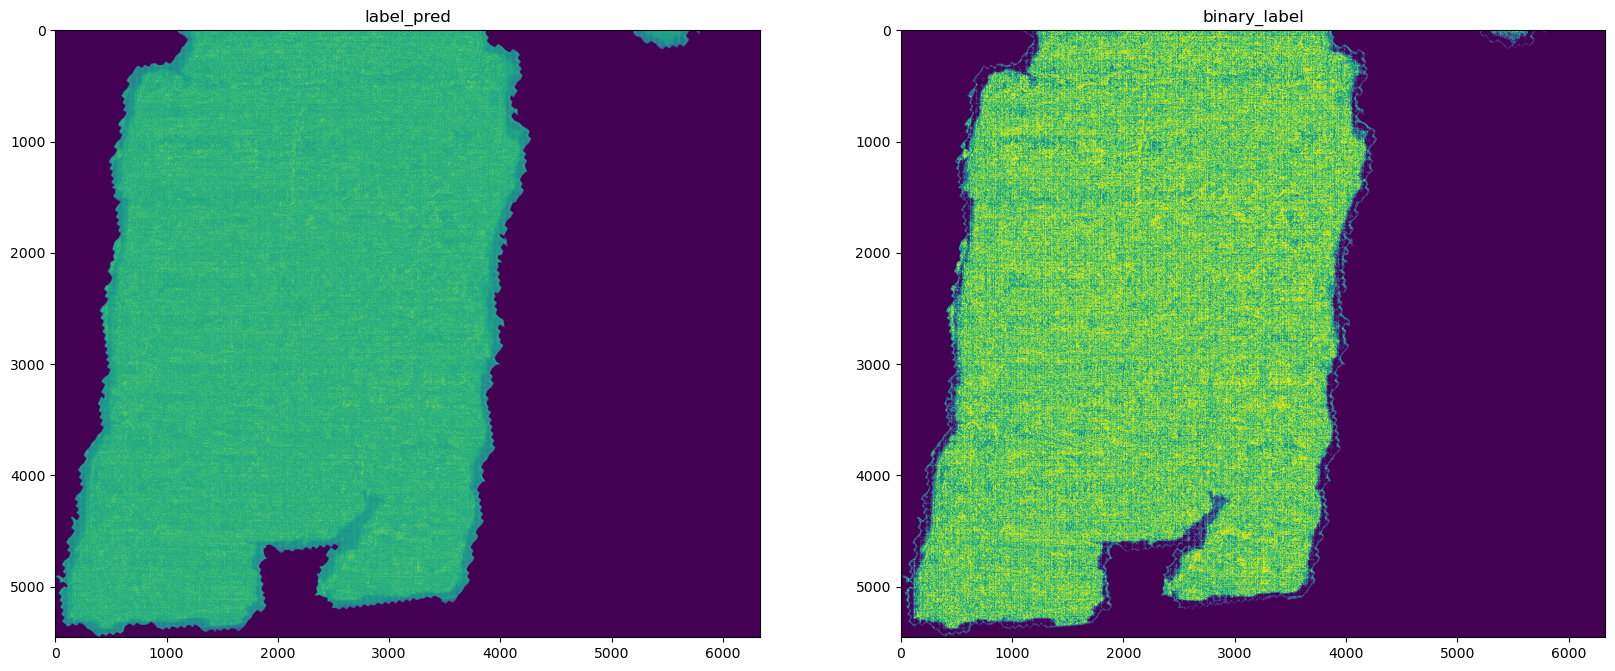

In [44]:
results = []

for id in ['a','b']:

    model, best_loss = build_model(cfg)

    model.th=0.96 if model.th == 0.5 else model.th
    model.to(device)
    img_set_ids = [id]

    label_pred = predict(img_set_ids, model, device, mode='test')
    label_rle=rle(label_pred)

    results.append((id, label_rle))




In [45]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])

In [46]:
sub.Id = sub.Id.astype(str)
sub

,Id,Predicted
0,a,207759 2 207764 1 207783 1 207792 3 214101 2 2...
1,b,1098 4 1103 73 1177 1 1179 27 1208 121 1330 43...


In [47]:
sample_sub = pd.read_csv(cfg['comp_dataset_path'] / 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
# sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')

In [48]:
sample_sub.to_csv('submission.csv', index=False)

In [49]:


if not is_kaggle:
    from wandb import AlertLevel
    wandb.alert(title="Training Finished", text="Training Finished ", level=AlertLevel.INFO)

In [50]:
wandb.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'